王良老师24年12月5日提供的新数据，使用的是未涉密的经纬度信息！

In [1]:
import tools.file as tf
from norfetools import plt
import norfetools as nt

import numpy as np
import pandas as pd
import copy
import pickle as pkl
from sklearn.neighbors import NearestNeighbors
import numpy as np
import math
import time
import requests

In [3]:
import geopandas as gpd

# 读取Shapefile文件
gdf = gpd.read_file('./Data/Network-New/Network_Final_Y2022-wgs84.shp')

# 打印GeoDataFrame的前几行来检查数据
print(gdf.head())

   A      B  DISTANCE  LINKTYPE NAME  TIME_SPD  CAPACITY  LANES  SPEED  SCRNO  \
0  1  25131   0.13791        22   CC         5     99999      9      5      0   
1  1  25271   0.12515        22   CC         5     99999      9      5      0   
2  1  25375   0.13165        22   CC         5     99999      9      5      0   
3  1  25541   0.21009        22   CC         5     99999      9      5      0   
4  2  25327   0.03714        22   CC         5     99999      9      5      0   

   BUSLANE  ONEWAY BUSPERIOD  LINKID2014  CNTID  CAPPERLANE  FLAG  \
0        0       0      None           0      0     11111.0     0   
1        0       0      None           0      0     11111.0     0   
2        0       0      None           0      0     11111.0     0   
3        0       0      None           0      0     11111.0     0   
4        0       0      None           0      0     11111.0     0   

                                            geometry  
0  LINESTRING (116.38314 39.90240, 116.3817

In [74]:
plt.figure(figsize=(6, 6))
gdf.plot(edgecolor='#324c7f', linewidth=0.3)
plt.axis('off')  # 隐藏坐标轴和边框
nt.SaveFig(1,"TotalNet.png","./Figure/RoadNet/")

<Figure size 600x600 with 0 Axes>

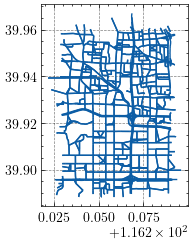

In [9]:
import geopandas as gpd
from shapely.geometry import box

# 读取Shapefile文件
# gdf = gpd.read_file('./Data/Network-New/Network_Final_Y2022-wgs84.shp')

# 定义一个矩形区域的边界框（这里需要您提供x_min, y_min, x_max, y_max）
# 例如，这些坐标可能代表经度和纬度
x_min, y_min, x_max, y_max = [116.23, 39.89, 116.29, 39.96]
bbox = box(x_min, y_min, x_max, y_max)

# 使用上述边界框来筛选GeoDataFrame中的数据
# 只选择与边界框相交的道路
roads_within_bbox = gdf[gdf.intersects(bbox)]

# 现在绘制这个区域内的路网
roads_within_bbox.plot()

# 显示图形
plt.show()


c:\Users\79323\.conda\envs\py3.7\lib\site-packages\ipykernel_launcher.py:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.


Number of intersections extracted: 477


<AxesSubplot:>

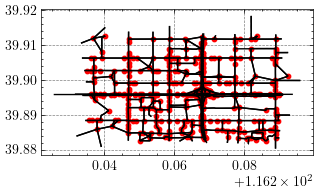

In [14]:
import geopandas as gpd
from shapely.geometry import box, MultiPoint
import matplotlib.pyplot as plt

# 读取Shapefile文件
# gdf = gpd.read_file('./Data/Network/Network_Final_Y2022.shp')

# 定义区域边界框
x_min, y_min, x_max, y_max = [116.235, 39.883, 116.29, 39.912]
bbox = box(x_min, y_min, x_max, y_max)

# 筛选出与边界框相交的路网数据
roads_within_bbox = gdf[gdf.intersects(bbox)]

# 创建一个空的GeoDataFrame来存储路口
intersections = gpd.GeoDataFrame(columns=['geometry'], crs=gdf.crs)

# 找出所有道路的相交点
for road1 in roads_within_bbox.geometry:
    for road2 in roads_within_bbox.geometry:
        if road1 == road2:  # 避免自己与自己相交
            continue
        intersection = road1.intersection(road2)
        if intersection.is_empty:  # 如果没有交点则跳过
            continue
        if "Point" == intersection.type:
            intersections = intersections.append({'geometry': intersection}, ignore_index=True)
        elif intersection.geom_type == "MultiPoint":
            for point in intersection.geoms:
                intersections = intersections.append({'geometry': point}, ignore_index=True)

        # 如果是线段相交，我们通常不将其视为一个路口，因此这里不考虑线与线相交


# 移除重复的路口位置
intersections = intersections.drop_duplicates(subset=['geometry'])
print(f"Number of intersections extracted: {len(intersections)}")

# 绘制边界框内的路网
roads_within_bbox.plot(ax=plt.gca(), color='black')

# 绘制路口
intersections.plot(ax=plt.gca(), color='red', markersize=10)

# 显示图形
# plt.show()
# Dplt.SaveFig(1,"CrossRoad.png","./Figure/RoadNet/")

In [59]:
import geopandas as gpd
from shapely.geometry import box

def extract_intersections_and_roads(shapefile_path, x_min, y_min, x_max, y_max):
    """
    Extracts intersections and roads within a bounding box from a given shapefile.

    Parameters:
    shapefile_path (str): The file path to the shapefile.
    x_min (float): The minimum x coordinate of the bounding box.
    y_min (float): The minimum y coordinate of the bounding box.
    x_max (float): The maximum x coordinate of the bounding box.
    y_max (float): The maximum y coordinate of the bounding box.

    Returns:
    intersections (GeoDataFrame): The intersections within the bounding box.
    roads_within_bbox (GeoDataFrame): The roads within the bounding box.
    """

    # 读取Shapefile文件
    gdf = gpd.read_file(shapefile_path)

    # 定义区域边界框
    bbox = box(x_min, y_min, x_max, y_max)

    # 筛选出与边界框相交的路网数据
    roads_within_bbox = gdf[gdf.intersects(bbox)]

    # 创建一个空的GeoDataFrame来存储路口
    intersections = gpd.GeoDataFrame(columns=['geometry'], crs=gdf.crs)

    # 找出所有道路的相交点
    for road1 in roads_within_bbox.geometry:
        for road2 in roads_within_bbox.geometry:
            if road1.equals(road2):  # 避免自己与自己相交
                continue
            intersection = road1.intersection(road2)
            if intersection.is_empty:  # 如果没有交点则跳过
                continue
            if "Point" == intersection.geom_type:
                intersections = intersections.append({'geometry': intersection}, ignore_index=True)
            elif "MultiPoint" == intersection.geom_type:
                for point in intersection.geoms:
                    intersections = intersections.append({'geometry': point}, ignore_index=True)
            # 不考虑线与线相交作为路口

    # 移除重复的路口位置
    intersections = intersections.drop_duplicates(subset=['geometry'])

    return intersections, roads_within_bbox

# 使用示例
shapefile_path = './Data/Network-New/Network_Final_Y2022-wgs84.shp'
x_min, y_min, x_max, y_max = [116.2340, 39.883, 116.2910, 39.9113]
intersections, roads_within_bbox = extract_intersections_and_roads(shapefile_path, x_min, y_min, x_max, y_max)


In [60]:
from scipy.sparse import lil_matrix, csr_matrix

def simplify_network(adjacency_matrix, intersection_dict):
    if not isinstance(adjacency_matrix, lil_matrix):
        adjacency_matrix = adjacency_matrix.tolil()

    nodes_to_remove = set()
    for i in range(adjacency_matrix.shape[0]):
        # Get the indices of the non-zero elements in the row and column
        non_zero_in_row = adjacency_matrix[i].nonzero()[1]
        non_zero_in_col = adjacency_matrix[:, i].nonzero()[0]
        
        # Create a set of unique indices excluding the self-loop
        unique_indices = set(non_zero_in_row).union(set(non_zero_in_col)) - {i}

        if len(unique_indices) == 2:  # Node i has only two neighbors
            # Mark the node for removal
            nodes_to_remove.add(i)

            # Connect the two neighbors directly
            j, k = unique_indices
            adjacency_matrix[j, k] = 1
            adjacency_matrix[k, j] = 1

    # Remove the nodes from the adjacency matrix
    adjacency_matrix = adjacency_matrix.tolil()
    for node in nodes_to_remove:
        adjacency_matrix[node, :] = 0  # Remove all connections from node
        adjacency_matrix[:, node] = 0  # Remove all connections to node

    # Remove the nodes from the intersection dictionary
    for node in sorted(nodes_to_remove, reverse=True):
        del intersection_dict[node]

    # Create a new mapping for the remaining nodes
    remaining_nodes = list(set(range(adjacency_matrix.shape[0])) - nodes_to_remove)
    simplified_intersection_dict = {new_idx: intersection_dict[old_idx] for new_idx, old_idx in enumerate(remaining_nodes)}

    # Construct the new adjacency matrix with remaining nodes
    new_adjacency_matrix = adjacency_matrix[remaining_nodes, :][:, remaining_nodes]

    return simplified_intersection_dict, new_adjacency_matrix.tocsr()

# 使用示例
# simplified_intersection_dict, simplified_adjacency_matrix = simplify_network(adjacency_matrix, intersection_dict)

def visualize_simplified_network(intersection_dict, adjacency_matrix):
    # This function will plot the network using the intersection_dict and adjacency_matrix
    fig, ax = plt.subplots()

    # Plot the edges using adjacency_matrix
    for i in range(adjacency_matrix.shape[0]):
        for j in range(adjacency_matrix.shape[1]):
            if adjacency_matrix[i, j] != 0:
                point1 = intersection_dict[i][0]
                point2 = intersection_dict[j][0]
                # print(point1, point2)
                ax.plot([point1[0], point2[0]], [point1[1], point2[1]], 'k-', lw=0.5)

    # Plot the intersections using intersection_dict
    for idx, point in intersection_dict.items():
        ax.plot(point[0][0], point[0][1], 'o', markersize=4, color='#113368')

    plt.xlabel('Longitude(E°)')
    plt.ylabel('Latitude(N°)')
    # plt.show()

def direction_to_index(direction):
    mapping = {'east': 0, 'north': 1, 'west': 2, 'south': 3}
    return mapping.get(direction, -1)  # 如果方向是unknown，返回-1

def determine_direction(lat1, lon1, lat2, lon2):
    # 计算两点之间的角度（以北方为0度，顺时针）
    angle = np.degrees(np.arctan2(lon2 - lon1, lat2 - lat1)) % 360
    if (angle <= 45) or (angle > 315):
        return 'north'
    elif 45 < angle <= 135:
        return 'east'
    elif 135 < angle <= 225:
        return 'south'
    else:  # 225 < angle <= 315
        return 'west'

def update_road_attributes(road_attributes, road_attributes_last, connected_nodes, road_toward):
    # 遍历所有的路口
    for node_id, neighbors in connected_nodes.items():
        for neighbor in neighbors:
            # 获取两个节点之间的方向
            direction_info = road_toward.get((node_id, neighbor))
            
            # 如果没有方向信息或者方向是unknown，则跳过
            if not direction_info or direction_info['direction'] == 'unknown':
                continue

            # 根据方向获取对应的列索引
            col_index = direction_to_index(direction_info['direction'])

            # 生成随机的a和b的值，确保它们的和小于等于1
            a_value = np.random.uniform(0, 1)
            b_value = np.random.uniform(0, 1 - a_value)
            
            # 生成随机的q的值，范围在1到100之间
            q_value = np.random.randint(1, 101)
            
            # 更新road_attributes的值
            road_attributes['a'][node_id, col_index] = a_value
            road_attributes['b'][node_id, col_index] = b_value
            road_attributes['q'][node_id, col_index] = q_value
            
            # 更新road_attributes_last的值，这里我们假设它们与road_attributes相同
            # 如果需要不同的逻辑，您可以在这里进行调整
            road_attributes_last['a'][node_id, col_index] = a_value
            road_attributes_last['b'][node_id, col_index] = b_value
            road_attributes_last['q'][node_id, col_index] = q_value

    return road_attributes, road_attributes_last



In [61]:
import geopandas as gpd
import numpy as np
from scipy.sparse import lil_matrix
import numpy as np
import copy
from scipy.sparse import csr_matrix

# Helper function to find the index of the closest intersection to a given point
def find_closest_index(point, intersection_dict, threshold=300):
    closest_idx = None
    min_dist = float('inf')
    for idx, p in intersection_dict.items():
        dist = np.linalg.norm(np.array(point) - np.array(p))
        if dist < min_dist:
            closest_idx = idx
            min_dist = dist
    if min_dist > threshold:
        print(f"No close intersection found for point {point}, closest distance: {min_dist}")
        return None
    # print(f"Closest intersection for point {point} is {closest_idx} at distance {min_dist}")
    return closest_idx


def create_road_network(intersections_gdf, roads_gdf):
    # Create a dictionary of intersection positions
    intersection_dict = {}
    for idx, intersection in enumerate(intersections_gdf.geometry):
        coords = intersection.coords[:]  # 获取坐标数组
        if len(coords) >= 1:
            # 将坐标数组的第一个坐标作为路口位置
            intersection_dict[idx] = coords[0]
    
    # Initialize the adjacency matrix
    num_intersections = len(intersection_dict)
    adjacency_matrix = lil_matrix((num_intersections, num_intersections), dtype=int)

    for road in roads_gdf.itertuples():
        start_point = road.geometry.coords[0]
        end_point = road.geometry.coords[-1]
        start_idx = find_closest_index(start_point, intersection_dict)
        end_idx = find_closest_index(end_point, intersection_dict)
        if start_idx is not None and end_idx is not None:
            adjacency_matrix[start_idx, end_idx] = 1
            adjacency_matrix[end_idx, start_idx] = 1
        else:
            print(f"Failed to find intersections for road between {start_point} and {end_point}")


    # Converting the adjacency matrix to CSR format for more efficient matrix operations
    adjacency_matrix = adjacency_matrix.tocsr()
    
    return intersection_dict, adjacency_matrix


def extract_parameters(adjacency_matrix, location_dict):
    num_nodes = adjacency_matrix.shape[0]
    
    # 确保 adjacency_matrix 是稀疏矩阵形式
    if not isinstance(adjacency_matrix, csr_matrix):
        adjacency_matrix = csr_matrix(adjacency_matrix)
    
    # 初始化 X 和 X_last
    X = np.zeros((num_nodes, 4))
    X_last = np.zeros((num_nodes, 4))
    
    # 初始化 road_attributes 和 road_attributes_last
    road_attributes = {'a': np.zeros((num_nodes, 4)), 'b': np.zeros((num_nodes, 4)), 'q': np.zeros((num_nodes, 4))}
    road_attributes_last = {'a': np.zeros((num_nodes, 4)), 'b': np.zeros((num_nodes, 4)), 'q': np.zeros((num_nodes, 4))}

    
    # 初始化 connected_nodes 和 road_toward 字典
    connected_nodes = {}
    road_toward = {}

    # 构建 connected_nodes 字典
    for i in range(num_nodes):
        # 对于每个节点，找到所有相邻的节点（即邻接矩阵中的非零元素索引）
        neighbors = adjacency_matrix[i].nonzero()[1]
        connected_nodes[i] = neighbors.tolist()
    
    # 构建 road_toward 字典
    for i in range(num_nodes):
        for j in connected_nodes[i]:
            if (i, j) not in road_toward:
                direction = 'unknown'
                if i in location_dict and j in location_dict:
                    lat1, lon1 = location_dict[i]
                    lat2, lon2 = location_dict[j]
                    # 计算方向
                    direction = determine_direction(lat1, lon1, lat2, lon2)
                
                road_toward[(i, j)] = {'direction': direction}
                # 如果道路是双向的，也为相反方向添加条目
                if adjacency_matrix[j, i] > 0 and (j, i) not in road_toward:
                    # 需要根据(j, i)重新计算方向
                    opposite_direction = determine_direction(lat2, lon2, lat1, lon1)
                    road_toward[(j, i)] = {'direction': opposite_direction}
    
    road_attributes, road_attributes_last = update_road_attributes(road_attributes, road_attributes_last, connected_nodes, road_toward)

    return X, X_last, road_attributes, road_attributes_last, connected_nodes, road_toward


In [62]:

def remove_zero_degree_nodes(adjacency_matrix, location_dict):
    # 找到所有度数不为0的节点索引
    non_zero_degree_node_indices = np.where(adjacency_matrix.getnnz(1) > 0)[0]
    
    # 删除度数为0的节点对应的行和列
    adjacency_matrix = adjacency_matrix[non_zero_degree_node_indices, :][:, non_zero_degree_node_indices]

    # 创建一个新的字典来存储更新后的位置信息
    new_location_dict = {}

    # 创建一个映射表来映射旧索引到新索引
    index_mapping = {old_index: new_index for new_index, old_index in enumerate(non_zero_degree_node_indices)}

    # 更新location_dict
    for old_index, location in location_dict.items():
        # 使用映射表更新字典的键，如果旧索引不在映射表中，说明它是一个0度节点，不应该被包含在新的字典中
        if old_index in index_mapping:
            new_location_dict[index_mapping[old_index]] = location

    return adjacency_matrix, new_location_dict



Number of roads within bbox: 954
Sample road geometries: 1130    LINESTRING (116.26343 39.91146, 116.26342 39.9...
1131    LINESTRING (116.26343 39.91146, 116.26768 39.9...
1137    LINESTRING (116.25281 39.90368, 116.24940 39.9...
1138    LINESTRING (116.25281 39.90368, 116.25394 39.9...
1139    LINESTRING (116.25281 39.90368, 116.25396 39.9...
Name: geometry, dtype: geometry


TypeError: 'float' object is not subscriptable

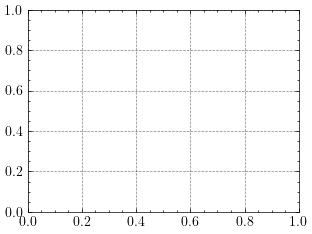

In [63]:
print(f"Number of roads within bbox: {len(roads_within_bbox)}")
print(f"Sample road geometries: {roads_within_bbox.geometry.head()}")

intersection_dict, adjacency_matrix = create_road_network(intersections, roads_within_bbox)

adjacency_matrix, intersection_dict = remove_zero_degree_nodes(adjacency_matrix, intersection_dict)

# Correct usage of the function
visualize_simplified_network(intersection_dict, adjacency_matrix)

X, X_last, road_attributes, road_attributes_last, connected_nodes, road_toward = extract_parameters(adjacency_matrix, intersection_dict)

print("X:", X)
print("X_last:", X_last)
print("road_attributes:", road_attributes)
print("connected_nodes:", connected_nodes)
print("road_toward:", road_toward)

In [67]:
import geopandas as gpd
import numpy as np
from scipy.sparse import lil_matrix

# Helper function to find the index of the closest intersection to a given point
def find_closest_index(point, intersection_dict, threshold=0.0001):
    for idx, p in intersection_dict.items():
        # np.allclose will compare the points with the given absolute tolerance
        if np.allclose(p[0], point, atol=threshold):
            return idx
    return None

# Assuming you already have the intersections GeoDataFrame
# intersections = ...

# Assigning a unique number to each intersection and creating a dictionary of positions
intersection_dict = {}
for idx, intersection in enumerate(intersections.geometry):
    intersection_dict[idx] = intersection.coords[:]

# Initializing the adjacency matrix
num_intersections = len(intersection_dict)
adjacency_matrix = lil_matrix((num_intersections, num_intersections), dtype=int)

# Assuming you have a GeoDataFrame of the road network with information about the roads
# This GeoDataFrame is called roads_within_bbox

# Filling the adjacency matrix
for road in roads_within_bbox.itertuples():
    start_point = road.geometry.coords[0]
    end_point = road.geometry.coords[-1]
    
    # Find the intersection number for the starting and ending points of the road
    start_idx = find_closest_index(start_point, intersection_dict)
    end_idx = find_closest_index(end_point, intersection_dict)
    
    # If both the start and end points correspond to an intersection number
    if start_idx is not None and end_idx is not None:
        # Set the edge in the adjacency matrix
        adjacency_matrix[start_idx, end_idx] = 1
        adjacency_matrix[end_idx, start_idx] = 1  # If it's a two-way road, also set the connection in the opposite direction

# Converting the adjacency matrix to CSR format for more efficient matrix operations
adjacency_matrix = adjacency_matrix.tocsr()


# 这样就创建了一个按图的数据结构存储的道路网络
# 其中 `intersection_dict` 是路口编号和位置的字典
# `adjacency_matrix` 是邻接矩阵，表示路口之间的直接连接状态

visualize_simplified_network(intersection_dict, adjacency_matrix)
nt.SaveFig(1,"area.png","./Figure/RoadNet/")


In [68]:
print(len(intersection_dict), np.sum(adjacency_matrix))

478 848


In [69]:
simplified_intersection_dict, simplified_adjacency_matrix = simplify_network(adjacency_matrix, intersection_dict)
# print(simplified_intersection_dict, simplified_adjacency_matrix)
visualize_simplified_network(simplified_intersection_dict, simplified_adjacency_matrix)
nt.SaveFig(1,"area-Simple.png","./Figure/RoadNet/")

In [70]:
print(len(simplified_intersection_dict), np.sum(simplified_adjacency_matrix))

393 647


In [76]:
def plot_combined_degree_distribution(adjacency_matrix):
    # 计算每个节点的出度和入度
    out_degrees = adjacency_matrix.sum(axis=0).A1  # 出度
    in_degrees = adjacency_matrix.sum(axis=1).A1  # 入度

    # 设定直方图的bins
    degree_range = max(max(out_degrees), max(in_degrees)) + 1
    bins = np.arange(degree_range)

    # 创建度数的分布直方图
    plt.figure(figsize=(4, 3))

    # 计算每个度的频率
    out_degree_count = np.bincount(out_degrees, minlength=degree_range)
    in_degree_count = np.bincount(in_degrees, minlength=degree_range)

    # 为直方图设置宽度和位置偏移
    bar_width = 0.35
    indices = np.arange(degree_range)

    # 绘制出度分布直方图
    plt.bar(indices - bar_width / 2, out_degree_count, bar_width, color='skyblue', label='Out-degree')

    # 绘制入度分布直方图
    plt.bar(indices + bar_width / 2, in_degree_count, bar_width, color='salmon', label='In-degree')

    plt.ylim(0,200)
    # 添加图例
    plt.legend(fontsize=9, ncol=2, loc='upper left')

    # 添加标题和轴标签
    # plt.title('Combined Degree Distribution')
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes $N$')
    plt.xticks(indices, indices)  # 设置x轴的刻度标签

    # 显示图表
    plt.tight_layout()

# 使用示例
plot_combined_degree_distribution(simplified_adjacency_matrix)
nt.SaveFig(1,"RoadNetDegree.png","./Figure/RoadNet/")
